2.3.0


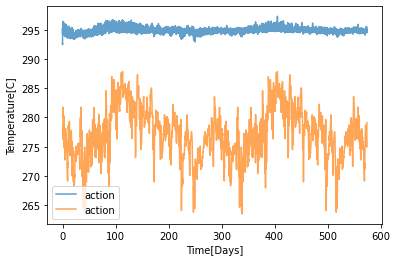

         Troom     Troom_t      Tamb_t  Valveout1  Supplytemp_t     tod_t  \
0   292.640205  292.640205  280.150000        0.0        303.15  0.000000   
1   292.444698  292.444698  280.150000        1.0        321.35  0.222222   
2   293.212209  293.212209  280.150000        0.0        303.15  0.444444   
3   293.560203  293.560203  280.150000        0.0        308.75  0.666667   
4   293.737125  293.737125  280.150000        1.0        318.55  0.888889   
5   294.263853  294.263853  280.150000        0.0        305.95  1.111111   
6   294.485549  294.485549  280.150000        1.0        308.75  1.333333   
7   294.703703  294.703703  280.150000        1.0        317.15  1.555556   
8   295.060600  295.060600  280.150000        0.0        319.95  1.777778   
9   295.089062  295.089062  280.150000        0.0        305.95  2.000000   
10  294.913948  294.913948  280.150000        0.0        311.55  2.222222   
11  294.866171  294.866171  280.150000        1.0        321.35  2.444444   

In [1]:

import matplotlib.pyplot as plt
import csv
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Sequential,callbacks,layers
from tensorflow.keras.layers import Dense, LSTM,Dropout,GRU,Bidirectional
from tensorflow.keras import regularizers
print(tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from numpy.random import seed 
import random

random_seed=2017
seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

# N_VALIDATION = int(1e3)
# N_TRAIN = int(1e4)
# BUFFER_SIZE = int(1e4)
# BATCH_SIZE = 32
# STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE


data_zone1=[]
data_actions=[]
data_out=[]
with open('output_zone1_extend.csv', 'r') as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        data_zone1.append(row)

csvFile.close()

with open('output_actions_extend.csv', 'r') as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        data_actions.append(row)

csvFile.close()


with open('output_out_extend.csv', 'r') as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        data_out.append(row)

csvFile.close()


df_actions = pd.DataFrame(data_actions)
df_actions.columns = ["Valve1", "Supplytemp","Reward","Hardcon","price_reward","sum_mix_reward","change_in_Supply_temp"]


df_zone1 = pd.DataFrame(data_zone1)
df_zone1.columns = ["Troom", "Tamb", "Valve","Power1","Reward","action",'Price','Power','Powerwater','Hcv','tod',"time"]


df_out = pd.DataFrame(data_out)
df_out.columns = ['RoomTemperature1','Valveout1','Power1','Tamb1','Sun1','Tambforecast1','Tambforecast2','Tambforecast3','Sunforecast1','Sunforecast2','Sunforecast3','Powerwater']


data = pd.concat([df_actions, df_zone1,df_out], axis=1, sort=False)


#remove Hardcon and HCV'Hardcon','Hcv','Hardcon': 'Hardcon_t', 'Hcv': 'Hcv_t',
dataset_t = data[['Troom', 'Tamb', 'Valveout1','Supplytemp','tod','Sun1','Sunforecast1','Tambforecast1']].copy()
dataset_t = dataset_t.rename(columns = {'Troom': 'Troom_t', 'Tamb': 'Tamb_t','Valve':'Valve_t' , 'Supplytemp': 'Supplytemp_t','tod':'tod_t','Sun1':'Sun1_t','Sunforecast1':'Sunforecast1_t','Tambforecast1':'Tambforecast1_t'}, inplace = False)

lables=data[['Troom']].copy()
lables.reset_index(inplace=True, drop=True)


dataset = pd.concat([dataset_t], axis=1, join='inner')#,dataset_tm1, dataset_tm2,dataset_tm3,dataset_tm4,dataset_tm5,dataset_tm6, dataset_tm7,dataset_tm8], axis=1, join='inner')#,dataset_tm5,dataset_tm6

len_lables=len(lables)

##dataset.drop([len_lables], inplace=True)#,len_dataset+1,len_dataset+2,len_dataset+3,len_dataset+4,len_dataset+5,len_dataset+6,len_dataset+7,len_dataset+8#,len_dataset+5,len_dataset+6

df_zone1=df_zone1.astype(float)
df_out=df_out.astype(float)
f1 = plt.figure(1)
#plt.style.use('ggplot')
plt.plot(df_zone1['time'],df_zone1['Troom'],label='action', alpha=0.7)
plt.plot(df_zone1['time'],df_out['Tambforecast1'],label='action', alpha=0.7)
#plt.plot(df_zone1['time'],df_zone1['Reward'],label='Hardconstraint', alpha=0.7)
#plt.plot(df_zone1_com['time'],df_zone1_com['Valve'],label='Valve ref pos', alpha=0.7)
plt.ylabel('Temperature[C]')
plt.xlabel('Time[Days]')
plt.legend()
plt.show()


dataset = pd.concat([lables,dataset_t], axis=1, join='inner')#,dataset_tm1, dataset_tm2,dataset_tm3,dataset_tm4,dataset_tm5, dataset_tm6,dataset_tm7,dataset_tm8], axis=1, join='inner')#,dataset_tm5,dataset_tm6


dataset=dataset.astype(float)
#dataset=dataset.round(decimals=4)


train_size = int(len(dataset)*0.30)
#test_size = int(len(dataset)*0.30)
train_dataset, test_dataset = dataset.iloc[:train_size],dataset.iloc[train_size:]
#Nothing, test_dataset = test_dataset.iloc[:test_size],test_dataset.iloc[test_size:]

print(train_dataset.head(30))
print(train_dataset.tail())
train_dataset_2=train_dataset.copy()
train_dataset_3=train_dataset.copy()
train_dataset_4=train_dataset.copy()
train_dataset_5=train_dataset.copy()
train_dataset = pd.concat([train_dataset,train_dataset_2,train_dataset_3], axis=0, join='inner')
train_dataset.reset_index(inplace=True, drop=True)
print(train_dataset.tail())

# Split train data to X and y
X_train = train_dataset.drop('Troom', axis = 1)
y_train = train_dataset.loc[:,['Troom']]
# Split test data to X and y
X_test = test_dataset.drop('Troom', axis = 1)
y_test = test_dataset.loc[:,['Troom']]


print(X_train.head(20))
#print(y_train.head(10))

# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))
# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)
# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)
# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

X_train_real=X_train
X_test_real=X_test.copy()
#print(train_x_norm[0:1,:])
#print('lable----',train_y_norm[1])
#print(train_dataset.head())



#
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        #print('-------',i+time_steps)
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        #print(Xs[i])
        #print(ys[i])
    return np.array(Xs), np.array(ys)


TIME_STEPS = 6
steps=5
number_of_runs=20

# for m in range(number_of_runs):
#   n=m*50
#   for i in range(steps): 
#     i=i+TIME_STEPS+n
#     X_test_real.iloc[i]['Troom_t']=0

X_train, y_train = create_dataset(train_x_norm, train_y_norm, 
                                  TIME_STEPS)

X_test, y_test = create_dataset(test_x_norm, test_y_norm,   
                                TIME_STEPS)

# print('X_train.shape: ', X_train.shape)
# print('y_train.shape: ', y_train.shape)
# print('X_test.shape: ', X_test.shape)
# print('y_test.shape: ', y_test.shape)
# a=X_train[1]
# print(X_train[1])
# print(a[TIME_STEPS-1][0])
# print('lable',y_train[0])
# print('-------')
# print(X_train[1])
# print('lable',y_train[1])
# print('-------')
# print(X_train[2])
# print('lable',y_train[2])
# print('-------')
print(X_train[1])
print('lable-test_label',y_train[0])
num_of_model=30

#print(X_test[:20][:])

# def create_model_bilstm_t0(units):
#     model = Sequential()
#     model.add(Bidirectional(LSTM(units = units,return_sequences=True),input_shape=(X_train.shape[1], X_train.shape[2])))
#     model.add(Bidirectional(LSTM(units = units)))
#     model.add(Dense(1))
#     #Compile model
#     model.compile(loss='mse', optimizer='adam')
#     return model

# # Create BiLSTM model
# def create_model_bilstm(units):
#     model = Sequential()
#     model.add(Bidirectional(LSTM(units = units,return_sequences=True),input_shape=(X_train.shape[1], X_train.shape[2])))
#     model.add(Dropout(0.2))
#     model.add(Bidirectional(LSTM(units = units,return_sequences=True)))
#     model.add(Dropout(0.2))
#     model.add(Bidirectional(LSTM(units = units)))
#     model.add(Dropout(0.2))
#     model.add(Dense(units = units))

#     model.add(Dense(1))
#     #Compile model
#     model.compile(loss='mse', optimizer='adam')
#     # lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#     # 0.0005,
#     # decay_steps=STEPS_PER_EPOCH*100,
#     # decay_rate=2,
#     # staircase=True)
#     # optimizer = tf.keras.optimizers.Adam(lr_schedule)
#     # model.compile(loss='mse',
#     #               optimizer=optimizer,
#     #               metrics=['mae', 'mse'])
#     return model


# Create LSTM or GRU model
# def create_model(units, m):
#     model = Sequential()
#     model.add(m (units = units, return_sequences = True,input_shape = [X_train.shape[1], X_train.shape[2]]))
#     model.add(Dropout(0.3))
#     model.add(m (units = units, return_sequences = True))
#     model.add(Dropout(0.3))
#     model.add(m (units = units))
#     model.add(Dropout(0.3))
#     model.add(Dense(units = 1))
#     #Compile model
#     model.compile(loss='mse', optimizer='adam')
#     # lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#     # 0.0005,
#     # decay_steps=STEPS_PER_EPOCH*1000,
#     # decay_rate=2,
#     # staircase=True)
#     # optimizer = tf.keras.optimizers.Adam(lr_schedule)

#     # model.compile(loss='mse',
#     #               optimizer=optimizer,
#     #               metrics=['mae', 'mse'])
#     return model

# model_list=[]
# # BiLSTM
# model_bilstm = create_model_bilstm_t0(64)
# model_bilstm_t1 = create_model_bilstm_t0(64)
# model_bilstm_t2 = create_model_bilstm_t0(64)
# model_bilstm_t3 = create_model_bilstm_t0(64)
# model_bilstm_t4 = create_model_bilstm_t0(64)
# model_bilstm_t5 = create_model_bilstm_t0(64)
# model_list.append(model_bilstm)
# model_list.append(model_bilstm_t1)
# model_list.append(model_bilstm_t2)
# model_list.append(model_bilstm_t3)
# model_list.append(model_bilstm_t4)
# model_list.append(model_bilstm_t5)
# for i in range(num_of_model-6):
#     model = create_model_bilstm_t0(64)
#     model_list.append(model)

# GRU and LSTM
# # model_bilstm = create_model(64 , GRU)
# # model_bilstm_t1 = create_model(64, GRU)
# # model_bilstm_t2 = create_model(64, GRU)
# # model_bilstm_t3 = create_model(64, GRU)
# # model_bilstm_t4 = create_model(64, GRU)
# # model_bilstm_t5 = create_model(64, GRU)
# # model_bilstm_t6 = create_model(64, GRU)
# # model_bilstm_t7 = create_model(64, GRU)
# # model_bilstm_t8 = create_model(64, GRU)
#model_lstm = create_model(64, LSTM)


def fit_model(model,X_train, y_train):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 20)
    history = model.fit(X_train, y_train, epochs = 100,
                        validation_split = 0.2, batch_size = 16,
                        shuffle = False, callbacks = [early_stop])
    return history





# Plot train loss and validation loss
def plot_loss (history):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

# Make prediction

def prediction_norm(model,data):
    prediction_norm = model.predict(data)
    #prediction = scaler_y.inverse_transform(prediction)
    return prediction_norm

def prediction(model,data):
    prediction = model.predict(data)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

def prediction_special(model,data):
    prediction_norm = model.predict(data)
    prediction = scaler_y.inverse_transform(prediction_norm)
    return prediction,prediction_norm


def evaluate_prediction(predictions, actual, model_name,modelnumber):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print('Mean Absolute Error[Kelvin] for model t:',modelnumber, mae)

def step_data_model(X,y,prediction_bilstm_norm,model_number):
    X_new=[]
    y_new=[]
    for i in range(len(X)-model_number):
        V=X[i+model_number].copy()
        V[TIME_STEPS-1][0]=prediction_bilstm_norm[i]
        X_new.append(V)
        lable=y[model_number+i]
        y_new.append(lable)
    return np.array(X_new), np.array(y_new)

def step_data_model_t2(X,y,prediction_bilstm_norm,prediction_bilstm_norm_t1,model_number):
    X_new=[]
    y_new=[]
    for i in range(len(prediction_bilstm_norm_t1)-model_number):
        V=X[i+model_number].copy()
        V[TIME_STEPS-2][0]=prediction_bilstm_norm[i]
        V[TIME_STEPS-1][0]=prediction_bilstm_norm_t1[i]
        X_new.append(V)
        lable=y[model_number+i]
        y_new.append(lable)
    return np.array(X_new), np.array(y_new)

def step_data_model_t3(X,y,prediction_bilstm_norm,prediction_bilstm_norm_t1,prediction_bilstm_norm_t2,model_number):
    X_new=[]
    y_new=[]
    for i in range(len(prediction_bilstm_norm_t1)-model_number):
        V=X[i+model_number].copy()
        V[TIME_STEPS-3][0]=prediction_bilstm_norm[i]
        V[TIME_STEPS-2][0]=prediction_bilstm_norm_t1[i]
        V[TIME_STEPS-1][0]=prediction_bilstm_norm_t2[i]
        X_new.append(V)
        lable=y[model_number+i]
        y_new.append(lable)
    return np.array(X_new), np.array(y_new)

def step_data_model_t4(X,y,prediction_bilstm_norm,prediction_bilstm_norm_t1,prediction_bilstm_norm_t2,prediction_bilstm_norm_t3,model_number):
    X_new=[]
    y_new=[]
    for i in range(len(prediction_bilstm_norm_t1)-model_number):
        V=X[i+model_number].copy()
        V[TIME_STEPS-4][0]=prediction_bilstm_norm[i]
        V[TIME_STEPS-3][0]=prediction_bilstm_norm_t1[i]
        V[TIME_STEPS-2][0]=prediction_bilstm_norm_t2[i]
        V[TIME_STEPS-1][0]=prediction_bilstm_norm_t3[i]
        X_new.append(V)
        lable=y[model_number+i]
        y_new.append(lable)
    return np.array(X_new), np.array(y_new)

def step_data_model_t5(X,y,prediction_bilstm_norm,prediction_bilstm_norm_t1,prediction_bilstm_norm_t2,prediction_bilstm_norm_t3,prediction_bilstm_norm_t4,model_number):
    X_new=[]
    y_new=[]
    for i in range(len(prediction_bilstm_norm_t1)-model_number):
        V=X[i+model_number].copy()
        V[TIME_STEPS-5][0]=prediction_bilstm_norm[i]
        V[TIME_STEPS-4][0]=prediction_bilstm_norm_t1[i]
        V[TIME_STEPS-3][0]=prediction_bilstm_norm_t2[i]
        V[TIME_STEPS-2][0]=prediction_bilstm_norm_t3[i]
        V[TIME_STEPS-1][0]=prediction_bilstm_norm_t4[i]
        X_new.append(V)
        lable=y[model_number+i]
        y_new.append(lable)
    return np.array(X_new), np.array(y_new)

def step_data_model_t6(X,y,prediction_bilstm_norm,prediction_bilstm_norm_t1,prediction_bilstm_norm_t2,prediction_bilstm_norm_t3,prediction_bilstm_norm_t4,prediction_bilstm_norm_t5,model_number):
    X_new=[]
    y_new=[]
    for i in range(len(prediction_bilstm_norm_t1)-model_number):
        V=X[i+model_number].copy()
        V[TIME_STEPS-6][0]=prediction_bilstm_norm[i]
        V[TIME_STEPS-5][0]=prediction_bilstm_norm_t1[i]
        V[TIME_STEPS-4][0]=prediction_bilstm_norm_t2[i]
        V[TIME_STEPS-3][0]=prediction_bilstm_norm_t3[i]
        V[TIME_STEPS-2][0]=prediction_bilstm_norm_t4[i]
        V[TIME_STEPS-1][0]=prediction_bilstm_norm_t5[i]
        X_new.append(V)
        lable=y[model_number+i]
        y_new.append(lable)
    return np.array(X_new), np.array(y_new)


In [4]:
import time
print(X_train[2][5])
print('lable-test_label',y_train[0])
print('lable-test_label',y_train[1])


[5.30812067e-01 6.83700186e-01 1.00000000e+00 7.14285714e-01
 6.54205607e-02 2.61470224e-07 2.61195047e-07 6.83487400e-01]
lable-test_label [0.47955112]
lable-test_label [0.53081207]


In [5]:
t1 = time.time()
model1 = keras.models.load_model("modelt1")
t2 = time.time()
print('time1',t2-t1)
model2 = keras.models.load_model("modelt2")
t3 = time.time()
print('time2',t3-t2)
model3 = keras.models.load_model("modelt3")
t4 = time.time()
print('time3',t4-t3)
model4 = keras.models.load_model("modelt4")
t5 = time.time()
print('time4',t5-t4)
model5 = keras.models.load_model("modelt5")
t6 = time.time()
print('time5',t6-t5)
model6 = keras.models.load_model("modelt6")
t7 = time.time()
print('time6',t7-t6)
model7 = keras.models.load_model("modelt7")
t8 = time.time()
print('time7',t8-t7)
model8 = keras.models.load_model("modelt8")
model9 = keras.models.load_model("modelt9")
model10 = keras.models.load_model("modelt10")
model11 = keras.models.load_model("modelt11")
print('end11')
model12 = keras.models.load_model("modelt12")
model13 = keras.models.load_model("modelt13")
model14 = keras.models.load_model("modelt14")
model15 = keras.models.load_model("modelt15")
model16 = keras.models.load_model("modelt16")
model17 = keras.models.load_model("modelt17")
print('end17')
model18 = keras.models.load_model("modelt18")
model19 = keras.models.load_model("modelt19")
model20 = keras.models.load_model("modelt20")
print('end20')
model21 = keras.models.load_model("modelt21")
model22 = keras.models.load_model("modelt22")
model23 = keras.models.load_model("modelt23")
model24 = keras.models.load_model("modelt24")
print('end24')
model25 = keras.models.load_model("modelt25")
model26 = keras.models.load_model("modelt26")
model27 = keras.models.load_model("modelt27")
model28 = keras.models.load_model("modelt28")
model29 = keras.models.load_model("modelt29")
print('end29')
model30 = keras.models.load_model("modelt30")
print('load models complet')
model_list=[model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,model21,model22,model23,model24,model25,model26,model27,model28,model29,model30]


time1 50.15950536727905
time2 51.693804025650024
time3 48.026145935058594
time4 53.77957272529602
time5 54.786526679992676
time6 51.77842950820923
time7 47.821187257766724
end11
end17
end20
end24
end29
load models complet


In [16]:
#y_test = scaler_y.inverse_transform(y_test)


X_new_test_list=[]
y_new_test_list=[]
pre_test_list=[]

prediction_test_norm_t0 = prediction_norm(model_list[0],X_test)

pre_test_list.append(prediction_test_norm_t0)

X_new_test_t1,y_new_test_t1=step_data_model(X_test,y_test,pre_test_list[0],1)
#y_new_test_t1 = scaler_y.inverse_transform(y_new_test_t1)
X_new_test_list.append(X_new_test_t1)
y_new_test_list.append(y_new_test_t1)

prediction_test_norm_t1 = prediction_norm(model_list[1],X_new_test_list[0])


pre_test_list.append(prediction_test_norm_t1)

X_new_test_t2,y_new_test_t2=step_data_model_t2(X_test,y_test,pre_test_list[0],pre_test_list[1],2)
#y_new_test_t2 = scaler_y.inverse_transform(y_new_test_t2)
X_new_test_list.append(X_new_test_t2)
y_new_test_list.append(y_new_test_t2)

prediction_test_norm_t2 = prediction_norm(model_list[2],X_new_test_list[1])

pre_test_list.append(prediction_test_norm_t2)

X_new_test_t3,y_new_test_t3=step_data_model_t3(X_test,y_test,pre_test_list[0],pre_test_list[1],pre_test_list[2],3)
#y_new_test_t3 = scaler_y.inverse_transform(y_new_test_t3)
X_new_test_list.append(X_new_test_t3)
y_new_test_list.append(y_new_test_t3)
prediction_test_norm_t3 = prediction_norm(model_list[3],X_new_test_list[2])

pre_test_list.append(prediction_test_norm_t3)

X_new_test_t4,y_new_test_t4=step_data_model_t4(X_test,y_test,pre_test_list[0],pre_test_list[1],pre_test_list[2],pre_test_list[3],4)
#y_new_test_t4 = scaler_y.inverse_transform(y_new_test_t4)
X_new_test_list.append(X_new_test_t4)
y_new_test_list.append(y_new_test_t4)
prediction_test_norm_t4 = prediction_norm(model_list[4],X_new_test_list[3])

pre_test_list.append(prediction_test_norm_t4)

X_new_test_t5,y_new_test_t5=step_data_model_t5(X_test,y_test,pre_test_list[0],pre_test_list[1],pre_test_list[2],pre_test_list[3],pre_test_list[4],5)
#y_new_test_t5 = scaler_y.inverse_transform(y_new_test_t5)
X_new_test_list.append(X_new_test_t5)
y_new_test_list.append(y_new_test_t5)
prediction_test_norm_t5 = prediction_norm(model_list[5],X_new_test_list[4])

pre_test_list.append(prediction_test_norm_t5)

X_new_test_t6,y_new_test_t6=step_data_model_t6(X_test,y_test,pre_test_list[0],pre_test_list[1],pre_test_list[2],pre_test_list[3],pre_test_list[4],pre_test_list[5],6)
#y_new_test_t6 = scaler_y.inverse_transform(y_new_test_t6)
X_new_test_list.append(X_new_test_t6)
y_new_test_list.append(y_new_test_t6)
prediction_test_norm_t6 = prediction_norm(model_list[6],X_new_test_list[5])

pre_test_list.append(prediction_test_norm_t6)




for i in range(num_of_model-7):
    i=i+6
    X_new_test,y_new_test=step_data_model_t6(X_test,y_test,pre_test_list[i-5],pre_test_list[i-4],pre_test_list[i-3],pre_test_list[i-2],    pre_test_list[i-1],pre_test_list[i],i+1)
    #y_new_test = scaler_y.inverse_transform(y_new_test)
    X_new_test_list.append(X_new_test)
    y_new_test_list.append(y_new_test)
    prediction_test_norm = prediction_norm(model_list[i+1],X_new_test_list[i])
    pre_test_list.append(prediction_test_norm)




prediction_test_list=[]

prediction_bilstm_test = prediction(model_list[0],X_test)
prediction_test_list.append(prediction_bilstm_test)

evaluate_prediction(prediction_bilstm_test, y_test, 'Bidirectional LSTM',1)


prediction_bilstm_test = prediction(model_list[1],X_new_test_list[0])
prediction_test_list.append(prediction_bilstm_test)
evaluate_prediction(prediction_test_list[1], y_new_test_list[0], 'Bidirectional LSTM',2)


for i in range(num_of_model-2):
    i=i+1
    prediction_bilstm_test = prediction(model_list[i+1],X_new_test_list[i])
    prediction_test_list.append(prediction_bilstm_test)
    evaluate_prediction(prediction_test_list[i+1], y_new_test_list[i], 'Bidirectional LSTM',i+2)


Mean Absolute Error[Kelvin] for model t: 1 0.06802517357352247
Mean Absolute Error[Kelvin] for model t: 2 0.17640968959788367
Mean Absolute Error[Kelvin] for model t: 3 0.2444512779438872
Mean Absolute Error[Kelvin] for model t: 4 0.31567382665085647
Mean Absolute Error[Kelvin] for model t: 5 0.35158861306817274
Mean Absolute Error[Kelvin] for model t: 6 0.4791026292901076
Mean Absolute Error[Kelvin] for model t: 7 0.6503802794567796
Mean Absolute Error[Kelvin] for model t: 8 0.7042111073477354
Mean Absolute Error[Kelvin] for model t: 9 0.8308749952314057
Mean Absolute Error[Kelvin] for model t: 10 0.9519145671858741
Mean Absolute Error[Kelvin] for model t: 11 0.8581414364219818
Mean Absolute Error[Kelvin] for model t: 12 1.1478311617414891
Mean Absolute Error[Kelvin] for model t: 13 1.160985574441871
Mean Absolute Error[Kelvin] for model t: 14 1.055895330654456
Mean Absolute Error[Kelvin] for model t: 15 0.9752743966233639
Mean Absolute Error[Kelvin] for model t: 16 0.8292537790563782

<ipython-input-17-992999e95058>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i+50)


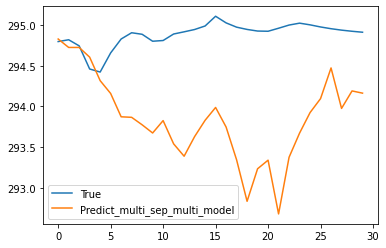

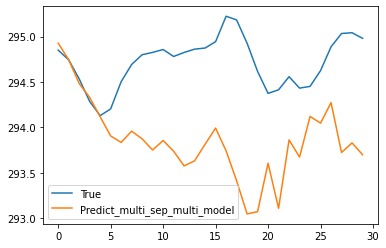

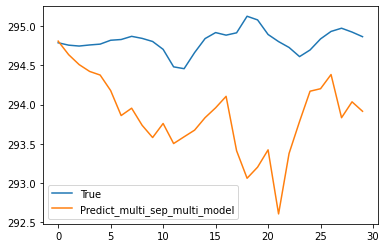

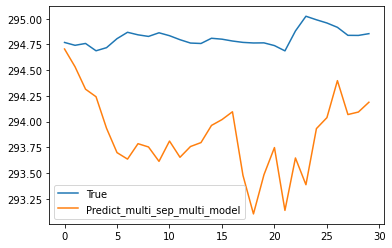

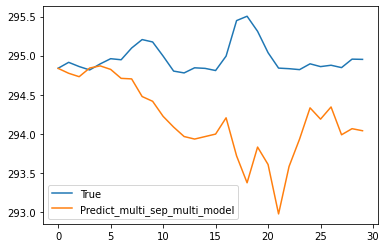

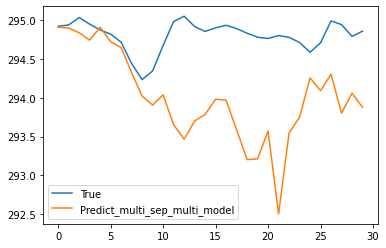

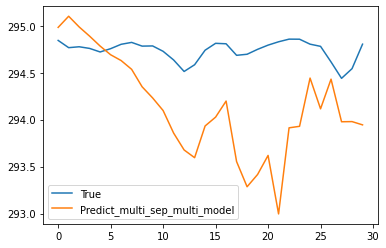

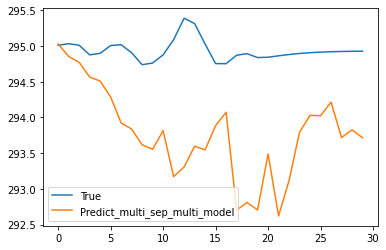

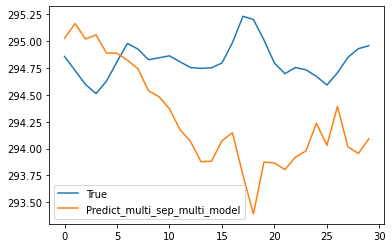

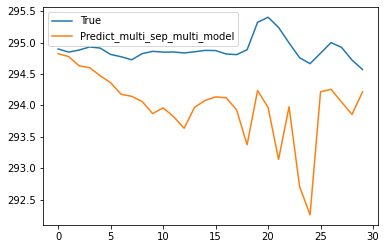

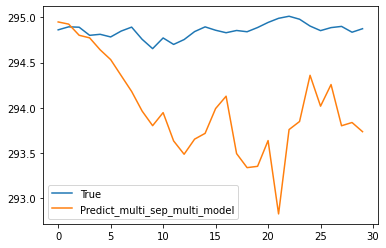

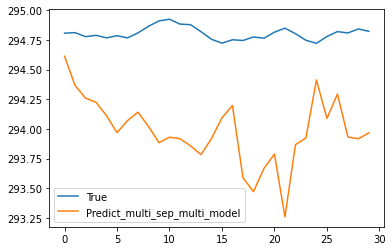

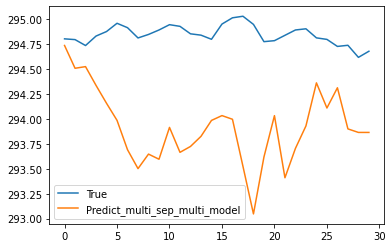

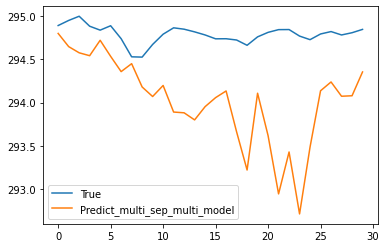

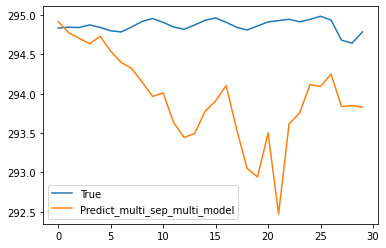

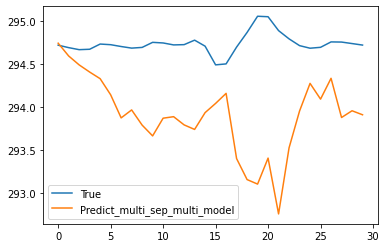

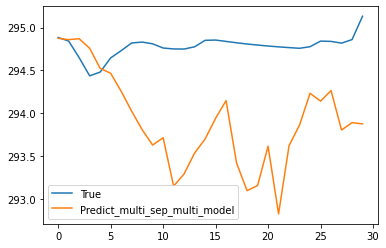

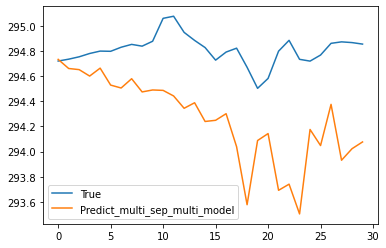

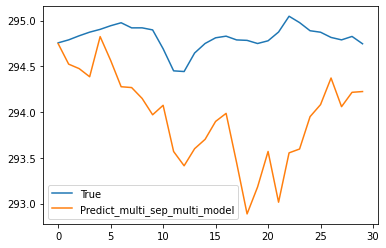

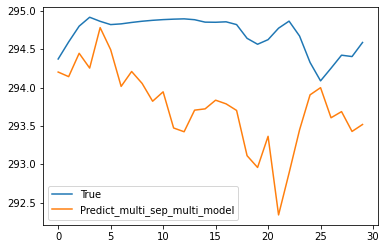

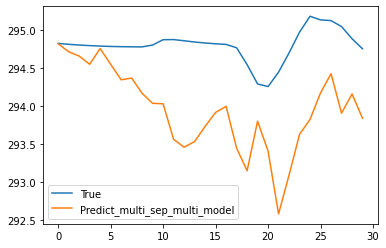

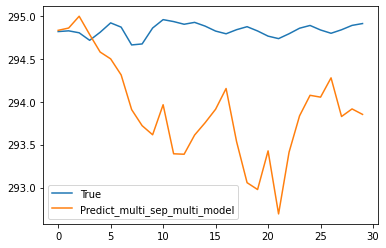

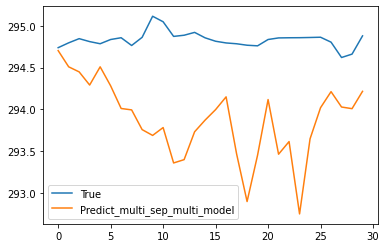

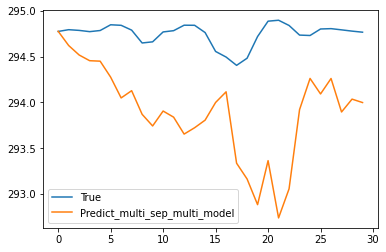

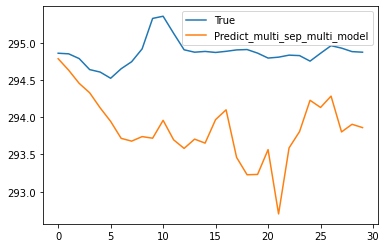

In [17]:
for i in range(25):
    i_i=i*300+10000
    
    predict_multi_step_multi_model=[]
    for n in range(num_of_model):
        predict_multi_step_multi_model.append(prediction_test_list[n][i_i])
    #predict_multi_step_multi_model=prediction_test_list[0][i_i:i_i+num_of_model]
    true_val=y_test[i_i:i_i+num_of_model]
    #predict_single_step_data=prediction_bilstm_test[i:i+16]

    plt.figure(i+50)
    plt.plot(true_val, label='True')
    #plt.plot(predict_data_multi_step,label='Predict')
    plt.plot(predict_multi_step_multi_model,label='Predict_multi_sep_multi_model')
    #plt.plot(predict_single_step_data,label='Predict_single_step')
    plt.legend()

In [15]:
for i in range(len(X_test)):#
    for n in range(6):#3
        #n=n*2
        X_test[i][n][2]=0#1
print(i)

43394


In [103]:
X_test

array([[[5.81098524e-01, 3.07140449e-01, 0.00000000e+00, ...,
         3.26503191e-07, 3.45998261e-07, 2.96450065e-01],
        [5.42527048e-01, 3.05041335e-01, 0.00000000e+00, ...,
         3.31698250e-07, 3.49137956e-07, 2.94094655e-01],
        [5.54367358e-01, 3.02824300e-01, 0.00000000e+00, ...,
         3.36441059e-07, 3.51816817e-07, 2.91739246e-01],
        [5.37260465e-01, 3.00488058e-01, 0.00000000e+00, ...,
         3.40728646e-07, 3.54034083e-07, 2.89383836e-01],
        [5.35408847e-01, 2.98134443e-01, 0.00000000e+00, ...,
         3.44558727e-07, 3.55789234e-07, 2.87028426e-01],
        [5.55333117e-01, 2.95780827e-01, 0.00000000e+00, ...,
         3.47929579e-07, 3.57081928e-07, 2.84673016e-01]],

       [[5.42527048e-01, 3.05041335e-01, 0.00000000e+00, ...,
         3.31698250e-07, 3.49137956e-07, 2.94094655e-01],
        [5.54367358e-01, 3.02824300e-01, 0.00000000e+00, ...,
         3.36441059e-07, 3.51816817e-07, 2.91739246e-01],
        [5.37260465e-01, 3.00488058e-0

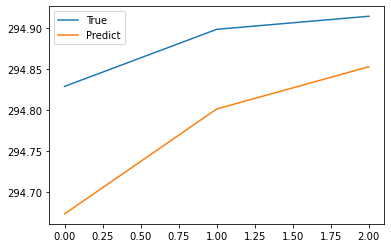

In [107]:
for m in range(1):
  n=m*300+12000
  true_val=[]
  predict_data=[]
  predict_data_norm=[]
  predict_single_step_data=[]
  for i in range(30):
    #print(X_test[i])
    if i > 6:
        num_for=6
    else:
        num_for=i
    
    
    i=i+n
    #print(i)
    if i>n:
      #c=X_test_real.iloc[(TIME_STEPS-1)+i]
      #c['Troom_t']=predi_bilstm
      #test_x_norm = input_scaler.transform(X_test_real)
      #X_test_pre, y_test_norm = create_dataset(test_x_norm, test_y_norm,TIME_STEPS)
      for i_s in range(num_for):
        i_s=i_s+1
        #print(i)
        if i_s > 6:
            i_modi=i_s+(i_s-6)
        else:
            i_modi=i_s
        X_test[6-(i_s)][0]=predict_data_norm[i_modi-1]
      
      
      a=np.expand_dims(X_test[i], axis=0)
      b=np.expand_dims(X_test[i], axis=0)
    else:
      a=np.expand_dims(X_test[i], axis=0)
      b=np.expand_dims(X_test[i], axis=0)
    #print('-------------------------------------------------')
    #print(b)
    predi_bilstm_single_step = prediction(model_list[0],a)
    predi_bilstm,predi_bilstm_norm = prediction_special(model_list[0],b)
    tv=y_test[i]

    predict_data_norm.insert(0, predi_bilstm_norm)
    true_val.append(y_test[i].tolist())
    predict_data.append(predi_bilstm[0].tolist())
    predict_single_step_data.append(predi_bilstm_single_step[0].tolist())

  plt.figure(m+10)
  plt.plot(true_val, label='True')
  plt.plot(predict_data,label='Predict')
  #plt.plot(predict_single_step_data,label='Predict_single_step')
  plt.legend()
#print('-------------------------------------------------')
plt.show()